# CEAS 2008 EDA and Preprocessing

## 1 Import libraries

Import the required libraries for data manipulation, email and HTML parsing, text cleaning, and data visualisations.

In [1]:
print("Loading libraries...")

# Core libraries
import os
import pandas as pd
import numpy as np
import re # For regular expressions
import time # To time operations
import gdown

import kagglehub

# Email parsing
import email
from email import policy
from email.parser import BytesParser, Parser
from email.utils import parsedate_to_datetime, getaddresses

# HTML processing
from bs4 import BeautifulSoup

# Text processing
import unicodedata

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 50)

print("Libraries imported.\n")

Loading libraries...
Libraries imported.



## 2 Load raw CEAS 2008 data

In [2]:
CEAS_CSV_GDRIVE_FILE_ID = '1SEzMyobVD612wgK5Qj95NDNBiTJw2j4A'
CEAS_CSV_LOCAL_FILENAME = 'CEAS_08.csv'
gdrive_url_ceas_csv = f'https://drive.google.com/uc?id={CEAS_CSV_GDRIVE_FILE_ID}'

if not os.path.exists(CEAS_CSV_LOCAL_FILENAME):
    print(f"Downloading {CEAS_CSV_LOCAL_FILENAME} from Google Drive...")

    try:
        gdown.download(gdrive_url_ceas_csv, CEAS_CSV_LOCAL_FILENAME, quiet=False)
        print(f"{CEAS_CSV_LOCAL_FILENAME} downloaded successfully.")

    except Exception as e:
        print(f"ERROR downloading {CEAS_CSV_LOCAL_FILENAME}: {e}. Check File ID and share settings.")
        # Handle error, perhaps by stopping or ensuring df_ceas_raw remains empty

else:
    print(f"{CEAS_CSV_LOCAL_FILENAME} already exists in Colab runtime.")

CEAS_CSV_INPUT_PATH = CEAS_CSV_LOCAL_FILENAME # Use the downloaded/local file
df_ceas_raw = pd.DataFrame()

if os.path.exists(CEAS_CSV_INPUT_PATH):
    try:
        df_ceas_raw = pd.read_csv(CEAS_CSV_INPUT_PATH)
        print(f"Successfully loaded {CEAS_CSV_INPUT_PATH}. Shape: {df_ceas_raw.shape}")

        # Immediately print head and info to start your EDA
        print("\nRaw CEAS CSV head:")
        print(df_ceas_raw.head())
        print("\nRaw CEAS CSV info:")
        df_ceas_raw.info(show_counts=True)

    except Exception as e:
        print(f"Error loading CEAS_08.csv: {e}")

else:
    print(f"ERROR: {CEAS_CSV_INPUT_PATH} not found after download attempt.")

Downloading...
From: https://drive.google.com/uc?id=1SEzMyobVD612wgK5Qj95NDNBiTJw2j4A
To: /content/CEAS_08.csv
100%|██████████| 67.9M/67.9M [00:01<00:00, 49.6MB/s]


CEAS_08.csv downloaded successfully.
Successfully loaded CEAS_08.csv. Shape: (39154, 7)

Raw CEAS CSV head:
                                                   sender  \
0                        Young Esposito <Young@iworld.de>   
1                            Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet.psi.br>   
3                      Michael Parker <ivqrnai@pobox.com>   
4       Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2

## 3 Initial Data Exploration (EDA)

In [3]:
if not df_ceas_raw.empty:
    print("--- Column Names Confirmed ---")
    print(df_ceas_raw.columns.tolist())

    # Based on your examination:
    TEXT_COLUMN_NAME_CEAS = 'body'
    LABEL_COLUMN_NAME_CEAS = 'label'
    SUBJECT_COLUMN_NAME_CEAS = 'subject'
    # Other columns identified: 'sender', 'receiver', 'date', 'urls' (binary indicator)

    print(f"\nUsing text column: '{TEXT_COLUMN_NAME_CEAS}'")
    print(f"Using label column: '{LABEL_COLUMN_NAME_CEAS}'")
    print(f"Using subject column: '{SUBJECT_COLUMN_NAME_CEAS}'")

    print(f"\n--- Missing Values per Column ---")
    print(df_ceas_raw.isnull().sum())

    # Drop rows where essential columns (body, label, subject) are missing
    # (sender, receiver, date, urls_indicator might be allowed to have NaNs if not primary features)
    essential_cols = [TEXT_COLUMN_NAME_CEAS, LABEL_COLUMN_NAME_CEAS, SUBJECT_COLUMN_NAME_CEAS]
    df_ceas_raw.dropna(subset=essential_cols, inplace=True)
    print(f"\nShape after dropping NaNs in essential columns: {df_ceas_raw.shape}")


    print(f"\n--- Value Counts for Label Column ('{LABEL_COLUMN_NAME_CEAS}') ---")
    print(df_ceas_raw[LABEL_COLUMN_NAME_CEAS].value_counts(dropna=False))

    print(f"\n--- Value Counts for URLs presence indicator column ('urls') ---")

    # Check if 'urls' column exists
    if 'urls' in df_ceas_raw.columns:
        print(df_ceas_raw['urls'].value_counts(dropna=False))

    else:
        print("'urls' column not found in the CSV.")

    print(f"\n--- Example Text from Body Column ('{TEXT_COLUMN_NAME_CEAS}') (first 300 chars) ---")

    if not df_ceas_raw[TEXT_COLUMN_NAME_CEAS].empty:
        for content in df_ceas_raw[TEXT_COLUMN_NAME_CEAS].sample(min(3, len(df_ceas_raw))).astype(str):
            print(content[:300])
            print("-" * 30)

    else:
        print(f"No non-missing values found in the text column '{TEXT_COLUMN_NAME_CEAS}' for sampling.")

    print(f"\n--- Example Subjects from Subject Column ('{SUBJECT_COLUMN_NAME_CEAS}') ---")

    if not df_ceas_raw[SUBJECT_COLUMN_NAME_CEAS].empty:
        for content in df_ceas_raw[SUBJECT_COLUMN_NAME_CEAS].sample(min(3, len(df_ceas_raw))).astype(str):
            print(content)
            print("-" * 30)

    else:
        print(f"No non-missing values found in the subject column '{SUBJECT_COLUMN_NAME_CEAS}' for sampling.")

else:
    print("Raw CEAS DataFrame is empty. Skipping EDA.")

--- Column Names Confirmed ---
['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

Using text column: 'body'
Using label column: 'label'
Using subject column: 'subject'

--- Missing Values per Column ---
sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

Shape after dropping NaNs in essential columns: (39126, 7)

--- Value Counts for Label Column ('label') ---
label
1    21829
0    17297
Name: count, dtype: int64

--- Value Counts for URLs presence indicator column ('urls') ---
urls
1    26227
0    12899
Name: count, dtype: int64

--- Example Text from Body Column ('body') (first 300 chars) ---
>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from CNN.com >Top videos and stories as of: Aug  1, 2008  3:58 PM EDT >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= TOP 10 VIDEOS 1. PARIS HILTON TAKES ON MCCAIN http://www.cnn.com/video/partners/email/i
------

## 4 Define preprocessing functions

Primarily use the `clean_text_content` function for the 'body' and 'subject' columns.

Since the 'body' column is likely pre-extracted email body text (possibly with HTML), our standard `clean_text_content` function (which includes basic HTML stripping) should work well.

In [4]:
def clean_text_content(text):
    if not isinstance(text, str):
      return ""

    # Step 1: Basic HTML Tag Removal (if CSV text column contains HTML)
    if bool(BeautifulSoup(text, "html.parser").find()):
        soup = BeautifulSoup(text, 'html.parser')

        for script_or_style in soup(["script", "style"]):
            script_or_style.decompose()

        text = soup.get_text(separator=' ', strip=True)

    # Step 2: Text Normalization and Cleaning
    text = unicodedata.normalize('NFKC', text)
    text = text.lower()

    # Remove URLs and email addresses before other punctuation if they are noisy
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', ' ', text)

    # Keep basic punctuation, replace other non-alphanumeric with space
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'\"$%()]", ' ', text)

    # Consolidate multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Strip text
    text = text.strip()

    return text

## 5 Apply preprocessing and label handling

Clean the 'body' and 'subject' text data. The 'label' column is already 0 or 1, so no complex mapping is needed, just ensuring correct data type.

Primarily extract phishing emails (label 1) from this dataset to combine with Enron ham for training.

In [5]:
df_processed_ceas = pd.DataFrame()

# Using the column names identified in Section 3
TEXT_COL = 'body'
LABEL_COL = 'label'
SUBJECT_COL = 'subject'

if not df_ceas_raw.empty and \
   TEXT_COL in df_ceas_raw.columns and \
   LABEL_COL in df_ceas_raw.columns and \
   SUBJECT_COL in df_ceas_raw.columns:

    print(f"Processing CEAS data using text column: '{TEXT_COL}', subject: '{SUBJECT_COL}', and label: '{LABEL_COL}'...")

    # Select relevant columns and create a working copy
    # Include other columns like 'sender', 'receiver', 'date', 'urls' if you plan to use them as features later
    relevant_cols = [TEXT_COL, SUBJECT_COL, LABEL_COL, 'sender', 'receiver', 'date', 'urls']
    # Filter out columns that might not exist if the user's CSV is slightly different

    existing_relevant_cols = [col for col in relevant_cols if col in df_ceas_raw.columns]
    df_temp_ceas = df_ceas_raw[existing_relevant_cols].copy()

    # Ensure label is integer
    df_temp_ceas[LABEL_COL] = df_temp_ceas[LABEL_COL].astype(int)

    # Clean the text columns
    print(f"Cleaning text in '{TEXT_COL}'...")
    start_time = time.time()
    df_temp_ceas['body_cleaned'] = df_temp_ceas[TEXT_COL].astype(str).apply(clean_text_content)

    print(f"Cleaning text in '{SUBJECT_COL}'...")
    df_temp_ceas['subject_cleaned'] = df_temp_ceas[SUBJECT_COL].astype(str).apply(clean_text_content)
    end_time = time.time()
    print(f"Text cleaning took {end_time - start_time:.2f} seconds.")

    # Select final columns for the processed dataframe
    # You can add more original columns if they are useful for later feature engineering
    cols_to_keep = ['body_cleaned', 'subject_cleaned', 'label']

    # Add back other potentially useful raw columns if they exist
    if 'sender' in df_temp_ceas.columns: cols_to_keep.append('sender')
    if 'receiver' in df_temp_ceas.columns: cols_to_keep.append('receiver')
    if 'date' in df_temp_ceas.columns: cols_to_keep.append('date') # Original date string
    if 'urls' in df_temp_ceas.columns: cols_to_keep.append('urls') # Original binary urls indicator

    df_processed_ceas = df_temp_ceas[cols_to_keep].copy()

    print(f"\nProcessed {len(df_processed_ceas)} emails from CEAS.")
    print("Processed CEAS head:")
    print(df_processed_ceas.head())
    print("\nLabel distribution in processed CEAS data:")
    print(df_processed_ceas['label'].value_counts(dropna=False)) # Should be 0s and 1s

else:
    print("Raw CEAS DataFrame is empty or essential columns ('body', 'label', 'subject') not identified correctly. Skipping preprocessing.")

Processing CEAS data using text column: 'body', subject: 'subject', and label: 'label'...
Cleaning text in 'body'...
Cleaning text in 'subject'...


<ipython-input-4-ebc6738754eb>:6: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a filename than HTML or XML.

If you meant to use Beautiful Soup to parse the contents of a file on disk, then something has gone wrong. You should open the file first, using code like this:

    filehandle = open(your filename)

You can then feed the open filehandle into Beautiful Soup instead of using the filename.

However, if you want to parse some data that happens to look like a filename, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  if bool(BeautifulSoup(text, "html.parser").find()):


Text cleaning took 16.91 seconds.

Processed 39126 emails from CEAS.
Processed CEAS head:
                                                                                                                                            body_cleaned  \
0  buck up, your troubles caused by small dimension will soon be over! become a lover no woman will be able to resist! come. even as nazi tanks were ...   
1                                                                                                   upgrade your sex and pleasures with these techniques   
2  the daily top 10 from cnn.com top videos and stories as of aug 1, 2008 3 58 pm edt top 10 videos 1. montauk 'monster' is it a devil dog? is it a t...   
3  would anyone object to removing .so from this list? the .so tld is basically dead and we've found that lots of bogus domains like lib .so are bein...   
4                                                                                                                     welcomefasts

## 6. Further EDA on Processed CEAS Data

Review characteristics of the cleaned and labeled CEAS data.

--- Descriptive Stats for Processed CEAS (lengths) ---
       body_cleaned_length  subject_cleaned_length
count         39126.000000            39126.000000
mean           1159.232582               37.383326
std            2954.415722               19.865568
min               0.000000                0.000000
25%             191.000000               24.000000
50%             494.000000               34.000000
75%            1373.000000               48.000000
max          122277.000000              284.000000

--- Stats by Label ---
       body_cleaned_length  subject_cleaned_length
label                                             
0              2068.752096               45.287853
1               438.541802               31.119886


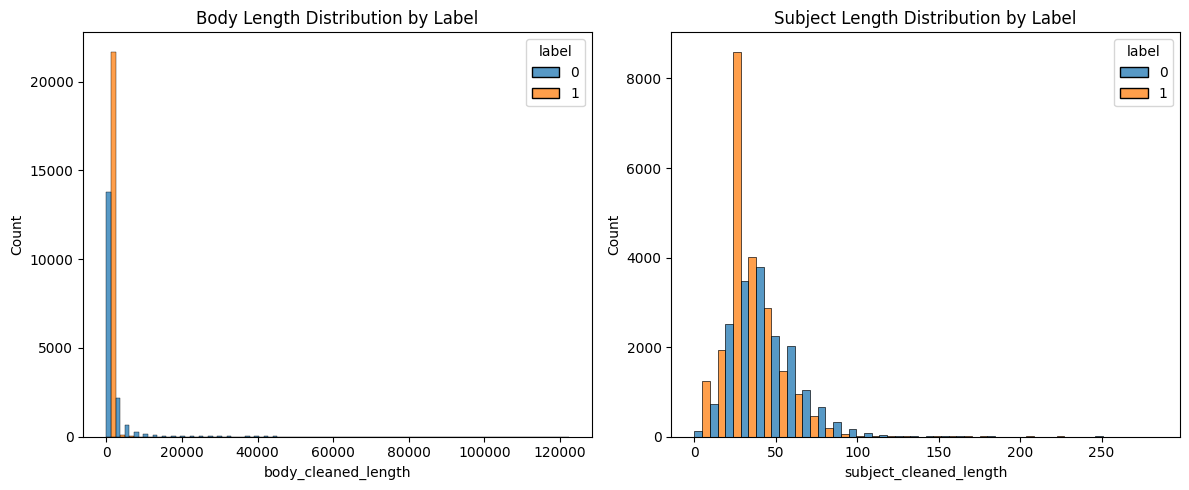

In [6]:
if not df_processed_ceas.empty:
    df_processed_ceas['body_cleaned_length'] = df_processed_ceas['body_cleaned'].apply(len)
    df_processed_ceas['subject_cleaned_length'] = df_processed_ceas['subject_cleaned'].apply(len)

    print("--- Descriptive Stats for Processed CEAS (lengths) ---")
    print(df_processed_ceas[['body_cleaned_length', 'subject_cleaned_length']].describe())

    print("\n--- Stats by Label ---")
    print(df_processed_ceas.groupby('label')[['body_cleaned_length', 'subject_cleaned_length']].mean())

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_processed_ceas, x='body_cleaned_length', hue='label', bins=50, kde=False, multiple="dodge")
    plt.title('Body Length Distribution by Label')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df_processed_ceas, x='subject_cleaned_length', hue='label', bins=30, kde=False, multiple="dodge")
    plt.title('Subject Length Distribution by Label')
    plt.tight_layout()
    plt.show()

else:
    print("Processed CEAS DataFrame is empty.")

## 7 Save processed CEAS data

Save the processed CEAS data. We are primarily interested in the phishing emails (label 1) from this set to combine with Enron ham for training. We will save these phishing emails separately. We can also save the ham emails from CEAS as an additional test set if desired.

In [7]:
if not df_processed_ceas.empty:

    # Save phishing emails (label 1) from CEAS for training combination
    df_ceas_phishing_for_training = df_processed_ceas[df_processed_ceas['label'] == 1].copy()

    if not df_ceas_phishing_for_training.empty:
        OUTPUT_FILENAME_CEAS_PHISHING = f'ceas08_phishing_for_training_{len(df_ceas_phishing_for_training)}.csv'
        df_ceas_phishing_for_training.to_csv(OUTPUT_FILENAME_CEAS_PHISHING, index=False)
        print(f"Processed CEAS (phishing for training) data saved to: /content/{OUTPUT_FILENAME_CEAS_PHISHING}")

    else:
        print("No phishing (label 1) emails found in processed CEAS to save for training.")

    # Optionally, save ham emails (label 0) from CEAS as an additional ham test set
    df_ceas_ham_for_testing = df_processed_ceas[df_processed_ceas['label'] == 0].copy()

    if not df_ceas_ham_for_testing.empty:
        OUTPUT_FILENAME_CEAS_HAM = f'ceas08_ham_for_testing_{len(df_ceas_ham_for_testing)}.csv'
        df_ceas_ham_for_testing.to_csv(OUTPUT_FILENAME_CEAS_HAM, index=False)
        print(f"Processed CEAS (ham for testing) data saved to: /content/{OUTPUT_FILENAME_CEAS_HAM}")

    else:
        print("No ham (label 0) emails found in processed CEAS to save for testing.")

else:
    print("Processed CEAS DataFrame is empty. Nothing to save.")

Processed CEAS (phishing for training) data saved to: /content/ceas08_phishing_for_training_21829.csv
Processed CEAS (ham for testing) data saved to: /content/ceas08_ham_for_testing_17297.csv
